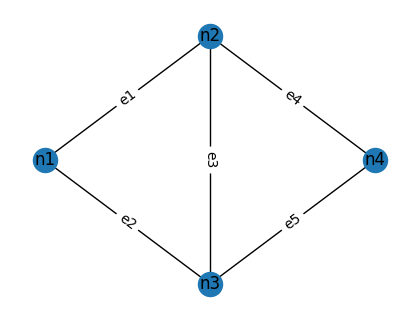

In [667]:
import sys
sys.path.append(r"D:\MINJI\NETWORK RELIABILITY\BNS-JT-python")

import numpy as np
from itertools import combinations
from scipy.stats import norm, multivariate_normal
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from tqdm import tqdm
from BNS_JT import variable
from networkx.algorithms.flow import shortest_augmenting_path

# Define the network
nodes = {'n1': (0, 0),
         'n2': (1, 1),
         'n3': (1, -1),
         'n4': (2, 0)}

edges = {'e1': ['n1', 'n2'],
         'e2': ['n1', 'n3'],
         'e3': ['n2', 'n3'],
         'e4': ['n2', 'n4'],
         'e5': ['n3', 'n4']}

probs = {'e1': 0.99, 'e2': 0.99, 'e3': 0.95, 'e4': 0.95, 'e5': 0.90}  # 엣지 신뢰도(survival probability)

%matplotlib inline
plt.figure(figsize=(4,3))
# Draw network
G = nx.Graph()
for node in nodes:
    G.add_node(node, pos=nodes[node])
for e, pair in edges.items():
    G.add_edge(*pair, label=e)

pos = nx.get_node_attributes(G, 'pos')
edge_labels=nx.get_edge_attributes(G, 'label')
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [668]:
varis = {}
for k, v in edges.items():
    varis[k] = variable.Variable( name=k, values = [0, 1]) # values: edge flow capacity

In [669]:
# Calculate beta using P(F_i)
beta = {}
for edge, survival_prob in probs.items():
    failure_prob = 1 - survival_prob  # P(F_i)
    beta[edge] = -norm.ppf(failure_prob)  # \u03B2_i = -\u03A6^(-1)(P(F_i))

# Print individual beta values
print("\nBeta values for each edge:")
for edge, beta_value in beta.items():
    print(f"Edge {edge}: Beta = {beta_value:.5f}")

# Define correlation coefficient matrix for n components
num_edges = len(edges)
corr_coeff = 0  # Example correlation coefficient
correlation_matrix = np.full((num_edges, num_edges), corr_coeff)
np.fill_diagonal(correlation_matrix, 1)  # Diagonal elements are 1

# Map edge indices to edge names
edge_names = list(edges.keys())

# Calculate beta for all combinations of failures
beta_values = list(beta.values())  # Extract beta values as a list
all_beta_results = {}

for k in range(2, num_edges + 1):  # From 2 components failing to all components
    all_combinations = list(combinations(range(num_edges), k))
    beta_joint_values = []

    for combo in all_combinations:
        beta_k = np.array([beta_values[i] for i in combo])  # Select beta values for this combination
        mean = np.zeros(k)
        cov = correlation_matrix[np.ix_(combo, combo)]  # Submatrix for the selected combination

        # Calculate P(F^k) for this combination
        prob_joint_failure = multivariate_normal.cdf(-beta_k, mean=mean, cov=cov)
        print(prob_joint_failure)
        beta_joint_k = -norm.ppf(prob_joint_failure)
        beta_joint_values.append((combo, beta_joint_k))

    # Store results for this k
    all_beta_results[k] = beta_joint_values

# Print results for each k
for k, beta_results in all_beta_results.items():
    print(f"\nBeta values for {k} components failing:")
    for combo, beta_value in beta_results:
        combo_edges = [edge_names[i] for i in combo]
        print(f"Combination {combo_edges}: Beta = {beta_value:.5f}")



Beta values for each edge:
Edge e1: Beta = 2.32635
Edge e2: Beta = 2.32635
Edge e3: Beta = 1.64485
Edge e4: Beta = 1.64485
Edge e5: Beta = 1.28155
0.00010000000000000007
0.0005000000000000004
0.0005000000000000004
0.0010000000000000009
0.0005000000000000004
0.0005000000000000004
0.0010000000000000009
0.002500000000000003
0.005000000000000006
0.005000000000000006
5.000000000000006e-06
5.000000000000006e-06
1.0000000000000013e-05
2.500000000000004e-05
5.000000000000008e-05
5.000000000000008e-05
2.500000000000004e-05
5.000000000000008e-05
5.000000000000008e-05
0.00025000000000000044
2.5000000000000047e-07
5.000000000000009e-07
5.000000000000009e-07
2.5000000000000053e-06
2.5000000000000053e-06
2.5000000000000062e-08

Beta values for 2 components failing:
Combination ['e1', 'e2']: Beta = 3.71902
Combination ['e1', 'e3']: Beta = 3.29053
Combination ['e1', 'e4']: Beta = 3.29053
Combination ['e1', 'e5']: Beta = 3.09023
Combination ['e2', 'e3']: Beta = 3.29053
Combination ['e2', 'e4']: Beta =

In [670]:
def net_conn(comps_st, od_pair, edges, varis): # maximum flow analysis

    G = nx.Graph()
    for k,x in comps_st.items():
        G.add_edge(edges[k][0], edges[k][1]) # we add each edge
        G[edges[k][0]][edges[k][1]]['capacity'] = varis[k].values[x] # define capacity as 0 if state = 0 or 1 if state = 1

    # perform maximum flow analysis between the OD pair
    G.add_edge(od_pair[1], 'new_d', capacity=1) # add a new edge with capacity 1 to ensure we find only ONE path. 
    f_val, f_dict = nx.maximum_flow(G, od_pair[0], 'new_d', capacity='capacity', flow_func=shortest_augmenting_path)

    if f_val > 0: # if the flow between the OD pair is greater than 0, the two nodes are connected
        sys_st = 's'

        # We can infer an associated minimum survival rule in case of network connectivity.
        min_comps_st = {} 
        for k, x in comps_st.items():
            k_flow = max([f_dict[edges[k][0]][edges[k][1]], f_dict[edges[k][1]][edges[k][0]]])
            if k_flow > 0: # the edges with flows > 0 consitute a minimum survival rule.
                min_comps_st[k] = 1

    else:
        sys_st = 'f'

        # In case of system failure, obtaining a minimum failure rule is not straightforward.
        min_comps_st = None

    return f_val, sys_st, min_comps_st

od_pair=('n1','n4')

In [671]:
# Example inputs
comps_st = {'e1': 0, 'e2': 0, 'e3': 0, 'e4': 0, 'e5': 0}
od_pair = ('n1', 'n4')  # Origin-Destination pair
edges = {'e1': ['n1', 'n2'],
         'e2': ['n1', 'n3'],
         'e3': ['n2', 'n3'],
         'e4': ['n2', 'n4'],
         'e5': ['n3', 'n4']}  # Edges
probs = {'e1': 0.99, 'e2': 0.99, 'e3': 0.95, 'e4': 0.95, 'e5': 0.90}  # Probabilities

varis = {}
for k, v in edges.items():
    varis[k] = variable.Variable(name=k, values=[0, 1])  # Define the variable states

# Call the net_conn function
f_val, sys_st, min_comps_st = net_conn(comps_st=comps_st, od_pair=od_pair, edges=edges, varis=varis)

# Print the return values
print("comp_st:", comps_st)
print("Flow Value (f_val):", f_val)
print("System State (sys_st):", sys_st)
print("Minimum Survival State (min_comps_st):", min_comps_st)


comp_st: {'e1': 0, 'e2': 0, 'e3': 0, 'e4': 0, 'e5': 0}
Flow Value (f_val): 0
System State (sys_st): f
Minimum Survival State (min_comps_st): None


In [672]:
num_edges = len(edges)
num_mece = 2 ** num_edges - 1  
mece = np.array([list(map(int, f"{i:0{num_edges}b}")) for i in range(1, 2 ** num_edges)])  
MCS_N = 10000


# Count variables for each MECE scenario
pi_count = np.zeros(num_mece)
case_details = {i: [] for i in range(num_mece)}  # Store detailed cases for each MECE scenario

# Monte Carlo simulation with progress bar
with tqdm(total=MCS_N, desc="Processing MCS iterations", file=sys.stdout) as pbar:
    for _ in range(MCS_N):
        # Randomly determine the state of each component (0: fail, 1: survive)
        comps_st = {e: np.random.choice([0, 1], p=[1 - probs[e], probs[e]]) for e in edges}
        failure_mask = np.array([1 if comps_st[e] == 0 else 0 for e in edges])  # Failure mask for components

        # Iterate through MECE scenarios
        for scn_idx in range(num_mece):
            if np.array_equal(mece[scn_idx], failure_mask):
                f_val, sys_st, _ = net_conn(comps_st=comps_st, od_pair=od_pair, edges=edges, varis=varis)

                # Record system failure state
                if sys_st == 'f':  # If system failed
                    pi_count[scn_idx] = MCS_N
                    if failure_mask.tolist() not in case_details[scn_idx]:
                        case_details[scn_idx].append(failure_mask.tolist())

                elif sys_st == 's':
                    # Explore additional failure scenarios
                    tmp_failure = np.sum(failure_mask)
                    max_attempts = 10  # Maximum number of attempts to detect new failures
                    attempts = 0

                    while tmp_failure < num_edges and attempts < max_attempts:
                        # Randomly fail one of the surviving components
                        surviving_comps = [e for e, state in comps_st.items() if state == 1]  # List of surviving components
                        if not surviving_comps:
                            break  # No surviving components to fail

                        # Randomly select a surviving component and fail it
                        selected_comp = np.random.choice(surviving_comps)
                        comps_st[selected_comp] = 0  # Fail the component

                        # Update failure mask
                        new_mask = np.array([1 if comps_st[e] == 0 else 0 for e in edges])
                        tmp_failure2 = np.sum(new_mask)

                        # If new failures are detected, check system state
                        if tmp_failure2 > tmp_failure:
                            f_val, sys_st, _ = net_conn(comps_st=comps_st, edges=edges, od_pair=od_pair, varis=varis)

                            if sys_st == 'f':  # If system failed
                                pi_count[scn_idx] += 1
                                if new_mask.tolist() not in case_details[scn_idx]:
                                    case_details[scn_idx].append(new_mask.tolist())

                            tmp_failure = tmp_failure2  # Update the failure count
                            attempts = 0  # Reset attempts since a new failure occurred
                        else:
                            attempts += 1  # Increment attempts if no new failures

                    # Break if no new failures occur after max_attempts
                    if attempts >= max_attempts:
                        break
        pbar.update(1)  # Update progress bar


pi_count[pi_count == 0] = MCS_N
sys_comp_prob = pi_count / MCS_N

state_combinations = [list(combinations(range(num_edges), k)) for k in range(1, num_edges + 1)]

# Flatten state_combinations for easier indexing
flat_combinations = [comb for sublist in state_combinations for comb in sublist]

print("\nCombination       | pi_count          | sys_comp_prob       | ratio")
print("----------------------------------------------------------------------")

for idx, combination in enumerate(flat_combinations):
    failure_prob_product = np.prod([1 - probs[f"e{comp + 1}"] for comp in combination])

    # Use the corresponding value from sys_comp_fail_prob for the numerator
    numerator = sys_comp_prob[idx] if idx < len(sys_comp_prob) else 1e-10

    if failure_prob_product > 0:
        denominator = failure_prob_product
        if sys_comp_prob[idx] == 1.0:  # Directly handle the case where ratio is set to 1
            ratio = 1.0
            pi_ratio_str = "1.000000"
        else:
            numerator2 = numerator * denominator
            ratio = numerator2 / denominator
            pi_ratio_str = f"{numerator2:.15f} / {denominator:.15f} = {ratio:.6f}"
    else:
        denominator = 1e-10
        ratio = float('inf')
        pi_ratio_str = "Division by zero, Ratio = inf"

    # Correct Combination formatting
    print(f"Combination: {tuple(f'e{comp + 1}' for comp in combination)} | {pi_count[idx]} | {sys_comp_prob[idx]:.15f} | {pi_ratio_str}")

# Display details for scenarios with pi_count < 10
print("\nDetails for MECE scenarios with pi_count < 10:")
for idx, cases in case_details.items():
    if pi_count[idx] < 50:
        print(f"Scenario {idx + 1}: pi_count = {pi_count[idx]}")
        for case in cases:
            print(f"  Failure Case: {case}")
    

Processing MCS iterations: 100%|██████████| 10000/10000 [00:02<00:00, 3652.81it/s]

Combination       | pi_count          | sys_comp_prob       | ratio
----------------------------------------------------------------------
Combination: ('e1',) | 2834.0 | 0.283400000000000 | 0.002834000000000 / 0.010000000000000 = 0.283400
Combination: ('e2',) | 1299.0 | 0.129900000000000 | 0.001299000000000 / 0.010000000000000 = 0.129900
Combination: ('e3',) | 10000.0 | 1.000000000000000 | 1.000000
Combination: ('e4',) | 1076.0 | 0.107600000000000 | 0.005380000000000 / 0.050000000000000 = 0.107600
Combination: ('e5',) | 171.0 | 0.017100000000000 | 0.001710000000000 / 0.100000000000000 = 0.017100
Combination: ('e1', 'e2') | 50.0 | 0.005000000000000 | 0.000000500000000 / 0.000100000000000 = 0.005000
Combination: ('e1', 'e3') | 10000.0 | 1.000000000000000 | 1.000000
Combination: ('e1', 'e4') | 255.0 | 0.025500000000000 | 0.000012750000000 / 0.000500000000000 = 0.025500
Combination: ('e1', 'e5') | 23.0 | 0

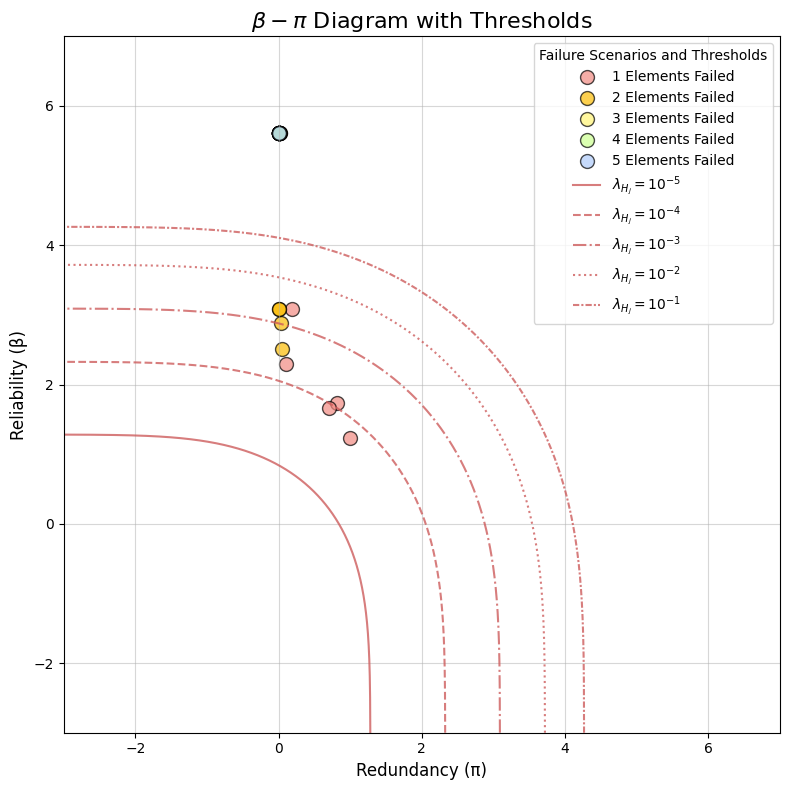

In [673]:
beta_values = -norm.ppf(sys_comp_fail_prob)  # Compute beta values
beta_values = np.clip(beta_values, -3, 7)

# Calculate the number of failed elements in each state
failed_elements = [sum(state) for state in mece]
unique_fail_counts = np.unique(failed_elements)

# Define colors for each unique fail count
dominant_colors_hex = ['#f28b82', '#fbbc04', '#fff475', '#ccff90', '#aecbfa', '#d7aefb']
colors = [to_rgb(color) for color in dominant_colors_hex[:len(unique_fail_counts)]]

# Plot the β-π Diagram
plt.figure(figsize=(8, 8))

# Scatter plot for each MECE state, grouped by number of failed elements
for fail_count, color in zip(unique_fail_counts, colors):
    indices = [i for i, x in enumerate(failed_elements) if x == fail_count]
    plt.scatter(np.array(redundancy)[indices], np.array(beta_values)[indices],
                color=color, s=100, label=f"{fail_count} Elements Failed", edgecolors='k', alpha=0.7)

# Add threshold lines for the β-π Diagram
prob_targets = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
reverse_labels = [r'$\lambda_{H_j} = 10^{-5}$', r'$\lambda_{H_j} = 10^{-4}$',
                  r'$\lambda_{H_j} = 10^{-3}$', r'$\lambda_{H_j} = 10^{-2}$',
                  r'$\lambda_{H_j} = 10^{-1}$']
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]  # Define line styles

for prob_target, line_style, label in zip(prob_targets, line_styles, reverse_labels):
    beta_threshold = np.arange(-3, 8, 1e-4)  # Optimize step size
    pi_threshold = -norm.ppf(prob_target / norm.cdf(-beta_threshold))
    plt.plot(pi_threshold, beta_threshold, 'indianred', linestyle=line_style,
             label=label, alpha=0.8)

# Customize the plot
plt.title(r'$\beta - \pi$ Diagram with Thresholds', fontsize=16)
plt.xlabel('Redundancy (π)', fontsize=12)
plt.ylabel('Reliability (β)', fontsize=12)
plt.xlim([-3, 7])
plt.ylim([-3, 7])
plt.grid(alpha=0.5)
plt.legend(title="Failure Scenarios and Thresholds", fontsize=10, loc="best")
plt.tight_layout()
plt.show()
